In [2]:
import os
import glob
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchsummary import summary

In [3]:
# CNN 网络模型
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(1, 10), stride=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool1 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 10), stride=1),
            nn.ReLU(inplace=True)
        )
        self.maxpool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 10), stride=1),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 10), stride=1),
            nn.ReLU(inplace=True)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=16 * 3 * 31, out_features=200),
            nn.ReLU(inplace=True)
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=200, out_features=1),
            nn.ReLU(inplace=True)
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=100, out_features=1),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x):
        batch_size = x.size(0)
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(batch_size, -1)
        x = self.fc1(x)
        x = self.fc2(x)
        # x = self.fc3(x)
        return x
    
# model = LeNet5().to(device)
# summary(model, (1, 3, 225))

In [4]:
# 创建 Dataset
class BatteryDataset(Dataset):
    def __init__(self, data):
        self.data = data
    def __len__(self):
        return len(self.data)
    def __getitem__(self, index):
        sequence, target = self.data[index]
        return torch.tensor(sequence, dtype=torch.float32).reshape(1, 3, 225), torch.tensor([target], dtype=torch.float32)

In [7]:
# 读取数据
data_path = "./data/124_commercial_cells/npy_files/"
data_files = sorted(glob.glob(os.path.join(data_path, "*.npy")))

# 划分训练集和测试集
def get_train_test_dataset(train_index=(4, 16), test_index=0):
    train_dataset = []
    test_dataset = []
    for i in range(train_index[0], train_index[1]):
        train_dataset += np.load(data_files[i], allow_pickle=True).tolist()
    test_dataset = np.load(data_files[test_index], allow_pickle=True)
    train_dataset = BatteryDataset(train_dataset)
    test_dataset = BatteryDataset(test_dataset)
    return train_dataset, test_dataset

train_dataset, test_dataset = get_train_test_dataset(train_index=(4, 16), test_index=0)
print(len(train_dataset), len(test_dataset))

# 创建 DataLoader
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True)
X, y = next(iter(train_dataloader))
print(X.shape, y.shape)

144975 11903
torch.Size([64, 1, 3, 225]) torch.Size([64, 1])


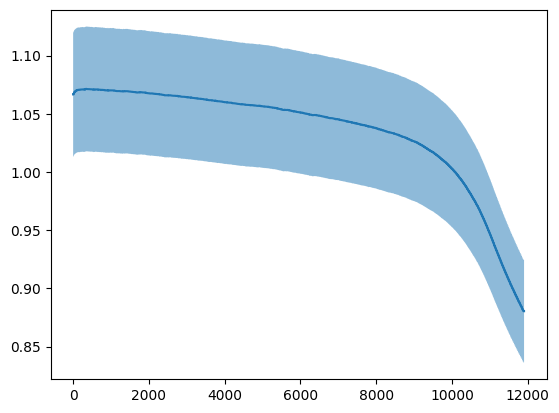

In [11]:
gt = []
for X, y in test_dataset:
    gt.append(float(y))

gt = np.array(gt)
y1 = gt * (1 + 0.05)
y2 = gt * (1 - 0.05)
plt.plot(gt)
cycle = np.arange(len(gt))
plt.fill_between(cycle, y2, y1, alpha=0.5)

In [12]:
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.constant_(m.bias, 0)
    # 也可以判断是否为conv2d，使用相应的初始化方式 
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    # 是否为批归一化层
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

using device: cuda
开始训练
epoch 1, train loss 0.002996303121710261, validation loss 0.0
epoch 2, train loss 0.000736367425007492, validation loss 0.0
epoch 3, train loss 0.0005583196034550581, validation loss 0.0
epoch 4, train loss 0.0003955776294347239, validation loss 0.0
epoch 5, train loss 0.00030443212182779627, validation loss 0.0
epoch 6, train loss 0.00026449268878925536, validation loss 0.0
epoch 7, train loss 0.0002205948703150168, validation loss 0.0
epoch 8, train loss 0.00019624943459650113, validation loss 0.0
epoch 9, train loss 0.00016853005753596884, validation loss 0.0
epoch 10, train loss 0.00015092901517730064, validation loss 0.0
epoch 11, train loss 0.00013692919554927156, validation loss 0.0
epoch 12, train loss 0.00012428628179055997, validation loss 0.0
epoch 13, train loss 0.00011689082480377159, validation loss 0.0
epoch 14, train loss 0.00010554779257028957, validation loss 0.0
epoch 15, train loss 0.00010551726444624519, validation loss 0.0
epoch 16, train l

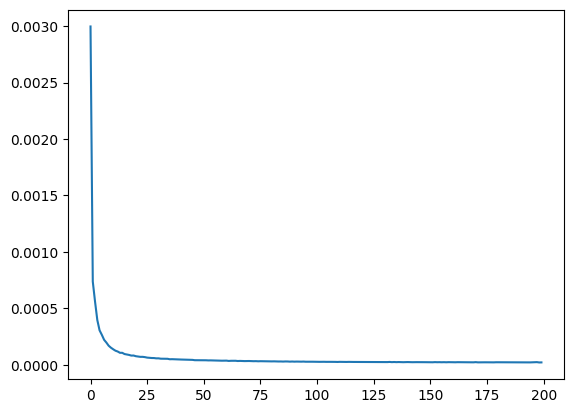

In [14]:
lr = 1e-3
epochs = 200
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using device: {device}")

torch.manual_seed(3407)
model = LeNet5().to(device)
model.apply(weight_init)
# print(model)
# summary(model, (1, 3, 255))
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# 模型训练
train_losses, val_losses = [], []
print("开始训练")
for epoch in range(epochs):
    model.train()
    train_loss, val_loss = 0.0, 0.0
    
    # 训练
    for X, y in train_dataloader:
        optimizer.zero_grad()
        X, y = X.to(device), y.squeeze().to(device)
        preds = model(X).squeeze()
        loss = criterion(preds, y)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    epoch_loss = train_loss / len(train_dataloader)
    train_losses.append(epoch_loss)
    print(f"epoch {epoch + 1}, train loss {epoch_loss}, validation loss {val_loss}")

print("训练完成")

plt.plot(train_losses)

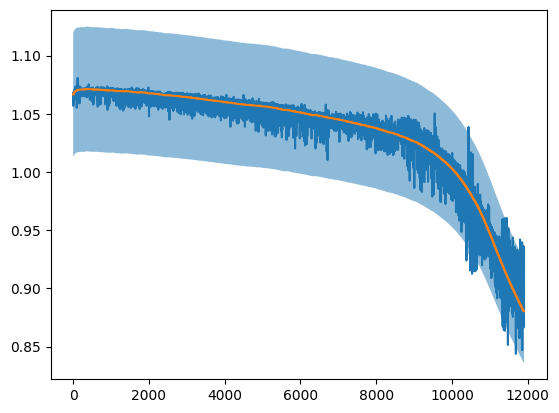

In [17]:
test_index = 0
test_dataset = np.load(data_files[test_index], allow_pickle=True)
test_dataset = BatteryDataset(test_dataset)
gt, pred = [], []
for X, y in test_dataset:
    gt.append(float(y))
    pred.append(float(model(X.to(device))))

gt = np.array(gt)
y1 = gt * (1 + 0.05)
y2 = gt * (1 - 0.05)
plt.plot(pred)
plt.plot(gt)
cycle = np.arange(len(gt))
plt.fill_between(cycle, y2, y1, alpha=0.5)

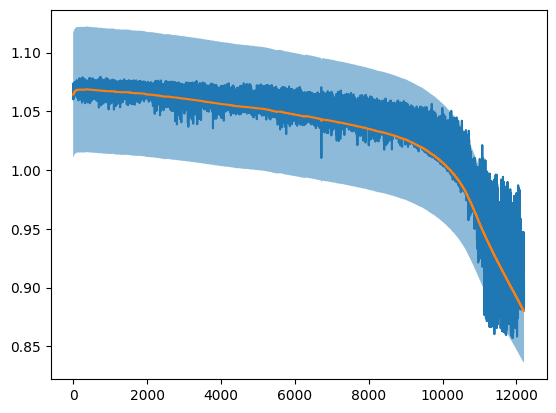

In [18]:
test_index = 1
test_dataset = np.load(data_files[test_index], allow_pickle=True)
test_dataset = BatteryDataset(test_dataset)
gt, pred = [], []
for X, y in test_dataset:
    gt.append(float(y))
    pred.append(float(model(X.to(device))))

gt = np.array(gt)
y1 = gt * (1 + 0.05)
y2 = gt * (1 - 0.05)
plt.plot(pred)
plt.plot(gt)
cycle = np.arange(len(gt))
plt.fill_between(cycle, y2, y1, alpha=0.5)

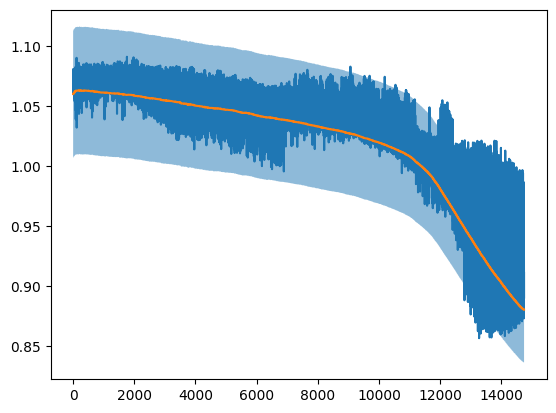

In [19]:
test_index = 2
test_dataset = np.load(data_files[test_index], allow_pickle=True)
test_dataset = BatteryDataset(test_dataset)
gt, pred = [], []
for X, y in test_dataset:
    gt.append(float(y))
    pred.append(float(model(X.to(device))))

gt = np.array(gt)
y1 = gt * (1 + 0.05)
y2 = gt * (1 - 0.05)
plt.plot(pred)
plt.plot(gt)
cycle = np.arange(len(gt))
plt.fill_between(cycle, y2, y1, alpha=0.5)

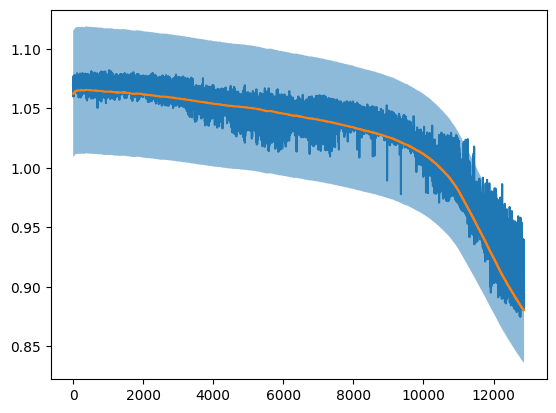

In [20]:
test_index = 3
test_dataset = np.load(data_files[test_index], allow_pickle=True)
test_dataset = BatteryDataset(test_dataset)
gt, pred = [], []
for X, y in test_dataset:
    gt.append(float(y))
    pred.append(float(model(X.to(device))))

gt = np.array(gt)
y1 = gt * (1 + 0.05)
y2 = gt * (1 - 0.05)
plt.plot(pred)
plt.plot(gt)
cycle = np.arange(len(gt))
plt.fill_between(cycle, y2, y1, alpha=0.5)

/tmp/ipykernel_11742/2443516400.py:20: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/home/lxh/miniconda3/envs/rul_prediction/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


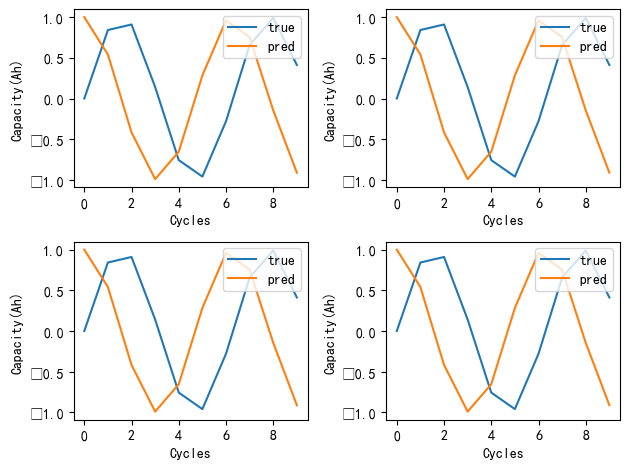

In [10]:
# 模型评估
x = np.array(range(10))
y = np.sin(x)
pred = np.cos(x)
num_cell = 4
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(x, y)
axes[0, 0].plot(x, pred)
axes[0, 1].plot(x, y)
axes[0, 1].plot(x, pred)
axes[1, 0].plot(x, y)
axes[1, 0].plot(x, pred)
axes[1, 1].plot(x, y)
axes[1, 1].plot(x, pred)
for i in range(2):
    for j in range(2):
        axes[i, j].set_xlabel("Cycles")
        axes[i, j].set_ylabel("Capacity(Ah)")
        axes[i, j].legend(["true", "pred"], loc="upper right")
plt.tight_layout()